
# Make Spread of Ground Truth

To get a ensemble, it is better to make a spread of ground truth which contains its uncertainty and variance. </br>
Start with simple and straight forward method such as randomly noised truth. 


---
---
## Prepare the data ##
In this example, only one-day (2020-06-01 GLO12) data is processed.

In [1]:
import xarray as xr

In [2]:
ncpath = "/Odyssey/public/glonet/2022-07-01_init_states"

In [3]:
ds1 = xr.open_dataset(ncpath + "/input1.nc")
ds2 = xr.open_dataset(ncpath + "/input2.nc")
ds3 = xr.open_dataset(ncpath + "/input3.nc")

Investigate the datasets

In [4]:
# ds1
# ds2
# ds3

Concatenate the input files by **ch** dimension

In [5]:
ds = xr.concat([ds1, ds2, ds3], dim="ch")
# Rename the ch coordinate from 0 to 85
ds = ds.assign_coords(ch=range(0, len(ds.ch)))
# Reorder the dimensions to time-ch-lat-lon
ds = ds.transpose("time", "ch", "lat", "lon")

---
---
## Perturbations ##

Now, the data is prepared. From this truth states, let's make some perturbations which contains physical meaning.
Here are some ideas.
1. Gaussian noise 
2. Climatological Anomaly
3. Pixel Displacement
4. Difference in time 
5. Distance from Observation  


--
### 1. Gaussian ###

Very frist straight forward thinking. We can imagine a randomly perturbated state in *Gaussian* distribution. </br>
1. Size of perturbations is different by variable. It means variance should be different by channel 'ch'
2. We assumed that the perturbation are in Normal distribution space.


In [6]:
import numpy as np

mean_by_ch = ds.mean(dim=("lat","lon")).isel(time=0)   # shape (ch,)
scale_by_ch = mean_by_ch                               # DataArray with dim 'ch'

In [7]:
rng = np.random.default_rng(42) # Set a randmo seed for reproductibility.
shape = (len(ds.time), len(ds.ch), len(ds.lat), len(ds.lon))

base_noise = xr.DataArray(
    rng.normal(loc=0.0, scale=1.0, size=shape),
    dims=("time","ch","lat","lon"),
    coords={"time": ds.time, "ch": ds.ch, "lat": ds.lat, "lon": ds.lon},
)

In [ ]:
# Set the perturbation magnitude to 10% of the mean value at each channel
perturb_1 = 0.1 * base_noise * scale_by_ch

--
### 2. Climatological anomaly ###

The anomaly isolates the time‑varying component of the field and therefore represents transient dynamical processes 
and slowly evolving departures. </br>
**How to compute** : subtract that climatological mean from the contemporaneous observation or 
model value at the same calendar time.

First, get climatology mean of GLORYS12 product.

In [9]:
clim1 = xr.open_dataset("/Odyssey/public/glonet/1993-06-01_climatology/mean1.nc")
clim2 = xr.open_dataset("/Odyssey/public/glonet/1993-06-01_climatology/mean2.nc")
clim3 = xr.open_dataset("/Odyssey/public/glonet/1993-06-01_climatology/mean3.nc")


In [10]:
clim = xr.concat([clim1, clim2, clim3], dim="ch")
# Rename the ch coordinate from 0 to 85
clim = clim.assign_coords(ch=range(0, len(clim.ch)))
# Reorder the dimensions to time-ch-lat-lon
clim = clim.transpose("time", "ch", "lat", "lon")

# Add time data from ds to clim
clim = clim.isel(time=0).assign_coords(time=ds.time[1])

Calculate anomaly by subtracting `ds - clim`

In [11]:
perturb_2 = ds - clim

--
### 3. Pixel displacement ###

Inspired by Shasank's work. </br>
Make displacement of latitude and longitude coordinates.

$$ \psi(x, y, z) = \psi(x + \delta x, \, y + \delta y, z, + \delta z)
$$

Rather than randomly generated displacement, we want to make a perturbation containing physics meaning.
The idea is perturb ocean state by displacing it along the local velocity field that is already data concerned.
To give a physical meaning, This perturbation mimics how small errors in position can propagate due to advection.
In other word, this method can create ensemble member that reflects how errors might propagte due to flow.

How to do ?
 - Assume that there is no depth level displacement: $\delta z = 0$
 1. For each grid point, compute a small displacement vector based on the local velocity $(u, \, v)$ 
 and a time-like scaling factor $\delta t$.
 2. Apply the displacement to the ocean states fields with *interpolation*.

$$ \psi(x, y, z) = \psi(x + \delta t \cdot u, \, y + \delta t \cdot v, z) 
$$

Last, add a stochasticity of the displacement.
define $dx$ and $dy$ as :

$$ dx = dt \, ( u(x, y, z) + \lambda \cdot \epsilon_{x}(x, y, z) )
$$
$$ dy = dt \, ( v(x, y, z) + \lambda \cdot \epsilon_{y}(x, y, z) )
$$

where, $\epsilon s$ are stochastic fields and $\lambda$ is scale factor for the error. </br>
Simplest stochasticity idea is adding Gaussian random field: $\epsilon$ ~ $N(\mu_{ch}, \sigma_{ch}^{2})$.
Where, $\mu$ is mean value of current for each channel and $\sigma$ stands for standard deviation for each channel.
For the simplicity, sptial correlation of the stochastic noise will be neglected.

***Remember that $(x_{new}, y_{new})$ represents change of the coordinates of state $\psi$.***


#### a. Extract ocean current data from dataset ####

In [12]:
# Extract u and v components for each depth level
uv_surface = ds["data"].isel(ch=slice(3, 5)) # SSH, T, s, u, v for surface
mean_uv_surface = uv_surface.mean(dim=("lat","lon"), skipna=True) # mean
std_uv_surface = uv_surface.std(dim=("lat","lon"), skipna=True) # standard deviation

uv_depth = {"d0" : uv_surface, "mean_d0": mean_uv_surface, "std_d0": std_uv_surface}

for depth in range(1, 11) : # T, s, u, v depth states for 20 depth levels
    uv_depth_da = ds["data"].isel(ch=[25 + depth, 34 + depth]) # u, v for depth level
    uv_depth[f"d{depth}"] = uv_depth_da
    uv_depth[f"mean_d{depth}"] = uv_depth_da.mean(dim=("lat","lon"), skipna=True)
    uv_depth[f"std_d{depth}"] = uv_depth_da.std(dim=("lat","lon"), skipna=True)

for depth in range(11, 21) : # T, s, u, v depth states for 20 depth levels
    uv_depth_da = ds["data"].isel(ch=[55 + depth, 64 + depth]) # u, v for depth level
    uv_depth[f"d{depth}"] = uv_depth_da
    uv_depth[f"mean_d{depth}"] = uv_depth_da.mean(dim=("lat","lon"), skipna=True)
    uv_depth[f"std_d{depth}"] = uv_depth_da.std(dim=("lat","lon"), skipna=True)

In [13]:
ds

<xarray.Dataset> Size: 658MB
Dimensions:  (time: 2, ch: 85, lat: 672, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 16B 2022-06-30 2022-07-01
  * lat      (lat) float64 5kB -78.0 -77.75 -77.5 -77.25 ... 89.25 89.5 89.75
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * ch       (ch) int64 680B 0 1 2 3 4 5 6 7 8 9 ... 76 77 78 79 80 81 82 83 84
Data variables:
    data     (time, ch, lat, lon) float32 658MB nan nan nan nan ... nan nan nan

#### b. Make Normal distributed noise. ####

In [14]:
import numpy as np

# Generate Gaussian normal noise for u and v components
rng = np.random.default_rng(42) # Set a random seed for reproducibility.
shape = (len(ds.time), len(ds.lat), len(ds.lon))

rng_x = xr.DataArray(
    rng.normal(loc=0.0, scale=1, size=shape),
    dims=("time","lat", "lon"),
    coords={"time": ds.time, "lat": ds.lat, "lon": ds.lon},
)

rng = np.random.default_rng(40)
rnd_y = xr.DataArray(
    rng.normal(loc=0.0, scale=1, size=shape),
    dims=("time","lat", "lon"),
    coords={"time": ds.time, "lat": ds.lat, "lon": ds.lon},
) 

In [15]:
# Set dt and lambda
dt = 5
lambda_ = 0.01

#### c. Combine $dt$, $(u, v)$ and $\epsilon$ to get $dx$ and $dy$. ####

In [16]:
dx = dt * (uv_depth["d0"].isel(ch=0) + 
      lambda_ * (rng_x * uv_depth["std_d0"].isel(ch=0) + uv_depth["mean_d0"].isel(ch=0)))  # u component for depth 0
dy = dt * (uv_depth["d0"].isel(ch=1) + 
      lambda_ * (rnd_y * uv_depth["std_d0"].isel(ch=1) + uv_depth["mean_d0"].isel(ch=1)))  # v component for depth 0


#### d. Make perturbation 3: global displacment ####
Simple is the best. Take a maximum dx and dy values and apply them for global scheme. </br>
Less physics but easy to implement.

In [17]:
dx_global = int(dx.max())
dy_global = int(dy.max())

#####  land mask #####

If we make a displacement from a random noise dataset, we may distrub the land pixel with the displacement. </br>
 land mask is expaned with the maximum size of displacement.


In [18]:
def create_land_mask(data, threshold=1e-10):
    """
    Create a land mask by detecting where data values are consistently zero or very small.
    This assumes land points have been masked or filled with zeros/very small values.
    """
    # Take the first time and first channel to detect land
    # Extract the 'data' variable from the dataset
    if hasattr(data, 'data'):
        sample_data = data.data.isel(time=0, ch=0)
    else:
        sample_data = data.isel(time=0, ch=0)
    
    # Create mask where values are NaN or very small (likely land)
    land_mask = np.isnan(sample_data) | (np.abs(sample_data) < threshold)
    
    return land_mask

# Create land mask from the dataset
print("Creating land mask...")
land_mask = create_land_mask(ds)

print(f"Land pixels: {np.sum(land_mask.values)}")
print(f"Land coverage: {100 * np.sum(land_mask.values) / land_mask.size:.1f}% of domain")

Creating land mask...
Land pixels: 292462
Land coverage: 30.2% of domain


##### Apply Displacement to All Channels #####

Now apply the complete displacement process to all 85 channels:
1. Extract `dx` and `dy`.
2. Create land mask to avoid land moving problem with ocean displacement.
3. Apply ocean displacement with NaN ocean filling to all channels.

In [19]:
# Apply displacement to ALL channels with CORRECT depth-dependent displacement
import numpy as np
from scipy.ndimage import map_coordinates
import time

def apply_ocean_displacement_complete(data, dx_global, dy_global, land_mask):
    """
    Complete displacement function with ocean gap filling mechanism
    """
    ny, nx = data.shape
    
    # Create a copy of the data to work with
    working_data = data.copy()
    
    # Set land pixels to NaN in working data to avoid interpolation artifacts
    working_data[land_mask.values] = np.nan
    
    # Create coordinate grids
    y_coords, x_coords = np.mgrid[0:ny, 0:nx]
    
    # Apply displacement
    new_y_coords = y_coords.astype(float) + dy_global
    new_x_coords = x_coords.astype(float) + dx_global
    
    # Apply displacement using interpolation
    displaced_data = map_coordinates(
        working_data,
        [new_y_coords, new_x_coords],
        order=1,                     # Linear interpolation
        mode='constant',             # Fill out-of-bounds with constant value
        cval=np.nan,                # Use NaN for out-of-bounds values
        prefilter=False
    )
    
    # Restore land pixels to original values (no displacement for land)
    displaced_data[land_mask.values] = data[land_mask.values]
    
    # Fill NaN values that appear in ocean areas due to displacement
    ocean_mask = ~land_mask.values
    nan_in_ocean = np.isnan(displaced_data) & ocean_mask
    
    if np.any(nan_in_ocean):
        # Option 1: Fill with original values where ocean became NaN
        displaced_data[nan_in_ocean] = data[nan_in_ocean]
        
        # Option 2: If there are still NaNs, use nearest neighbor interpolation
        remaining_nans = np.isnan(displaced_data) & ocean_mask
        if np.any(remaining_nans):
            # Find valid ocean values for interpolation
            valid_ocean = ~np.isnan(displaced_data) & ocean_mask
            if np.any(valid_ocean):
                # Get indices of valid points
                valid_indices = np.where(valid_ocean)
                
                if len(valid_indices[0]) > 0:
                    # For each invalid point, find the nearest valid point
                    invalid_indices = np.where(remaining_nans)
                    
                    for i in range(len(invalid_indices[0])):
                        y_invalid, x_invalid = invalid_indices[0][i], invalid_indices[1][i]
                        
                        # Find nearest valid point
                        distances = np.sqrt((valid_indices[0] - y_invalid)**2 + 
                                          (valid_indices[1] - x_invalid)**2)
                        nearest_idx = np.argmin(distances)
                        nearest_y, nearest_x = valid_indices[0][nearest_idx], valid_indices[1][nearest_idx]
                        
                        # Fill with nearest valid value
                        displaced_data[y_invalid, x_invalid] = displaced_data[nearest_y, nearest_x]
    
    return displaced_data

def create_land_mask_from_channel(data_array, threshold=1e-10):
    """
    Create a land mask from a single channel data array
    """
    # data_array should be 2D or 3D with time dimension
    if len(data_array.dims) == 3:  # (time, lat, lon)
        sample_data = data_array.isel(time=0)
    else:  # (lat, lon)
        sample_data = data_array
    
    land_mask = np.isnan(sample_data) | (np.abs(sample_data) < threshold)
    return land_mask

print("=" * 80)
print("APPLYING CORRECTED DEPTH-DEPENDENT DISPLACEMENT TO ALL CHANNELS")
print("=" * 80)

# Define channel structure by depth levels
depth_structure = {
    0: {"channels": list(range(0, 5)), "name": "Surface (SSH, T, S, U, V)"},
    1: {"channels": list(range(5, 9)), "name": "Depth 1 (T, S, U, V)"},
    2: {"channels": list(range(9, 13)), "name": "Depth 2 (T, S, U, V)"},
    3: {"channels": list(range(13, 17)), "name": "Depth 3 (T, S, U, V)"},
    4: {"channels": list(range(17, 21)), "name": "Depth 4 (T, S, U, V)"},
    5: {"channels": list(range(21, 25)), "name": "Depth 5 (T, S, U, V)"},
}

# Continue the pattern for all 21 depth levels (0-20)
for depth in range(6, 21):
    start_ch = 21 + (depth - 5) * 4
    depth_structure[depth] = {
        "channels": list(range(start_ch, start_ch + 4)), 
        "name": f"Depth {depth} (T, S, U, V)"
    }

print(f"Channel structure by depth:")
for depth, info in depth_structure.items():
    if depth < 5 or depth % 5 == 0:  # Show first few and every 5th depth
        print(f"  Depth {depth:2d}: channels {info['channels'][0]:2d}-{info['channels'][-1]:2d} - {info['name']}")
    elif depth == 5:
        print(f"  ... (showing every 5th depth)")



APPLYING CORRECTED DEPTH-DEPENDENT DISPLACEMENT TO ALL CHANNELS
Channel structure by depth:
  Depth  0: channels  0- 4 - Surface (SSH, T, S, U, V)
  Depth  1: channels  5- 8 - Depth 1 (T, S, U, V)
  Depth  2: channels  9-12 - Depth 2 (T, S, U, V)
  Depth  3: channels 13-16 - Depth 3 (T, S, U, V)
  Depth  4: channels 17-20 - Depth 4 (T, S, U, V)
  Depth  5: channels 21-24 - Depth 5 (T, S, U, V)
  Depth 10: channels 41-44 - Depth 10 (T, S, U, V)
  Depth 15: channels 61-64 - Depth 15 (T, S, U, V)
  Depth 20: channels 81-84 - Depth 20 (T, S, U, V)


In [20]:
# Create depth-dependent displacements and land masks
print(f"\nPreparing depth-dependent displacements...")
print(f"Using uv_depth dictionary with {len(uv_depth)} depth levels")

# Extract displacement fields for each depth level from uv_depth dictionary
depth_displacements_corrected = {}
depth_land_masks_corrected = {}

for depth in range(21):  # 0 to 20
    depth_key = f"d{depth}"
    
    if depth_key in uv_depth:
        print(f"  Processing depth {depth} using uv_depth['{depth_key}']...")
        
        # Get u, v data for this depth from uv_depth dictionary
        uv_data = uv_depth[depth_key]  # Should contain u, v for this depth
        mean_data = uv_depth[f"mean_{depth_key}"]
        std_data = uv_depth[f"std_{depth_key}"]
        
        # Extract u and v components (assuming ch=0 is u, ch=1 is v)
        u_depth = uv_data.isel(ch=0)
        v_depth = uv_data.isel(ch=1)
        u_mean = mean_data.isel(ch=0) 
        v_mean = mean_data.isel(ch=1)
        u_std = std_data.isel(ch=0)
        v_std = std_data.isel(ch=1)
        
        # Create displacement using same parameters as original surface calculation
        dx_depth = dt * (u_depth + lambda_ * (rng_x * u_std + u_mean))
        dy_depth = dt * (v_depth + lambda_ * (rnd_y * v_std + v_mean))
        
        # Create land mask for this depth using temperature channel
        temp_ch = depth_structure[depth]["channels"][0]  # First channel (temperature)
        temp_data = ds["data"].isel(ch=temp_ch)
        land_mask_depth = create_land_mask_from_channel(temp_data)

        
        # Convert to global displacement values
        dx_global_depth = int(dx_depth.max())
        dy_global_depth = int(dy_depth.max())
        
        print(f"    -> dx_global={dx_global_depth:3d}, dy_global={dy_global_depth:3d}")
        
    else:
        print(f"  Depth {depth} not in uv_depth dictionary, using surface parameters...")
        # Use surface parameters as fallback
        dx_depth = dx
        dy_depth = dy
        land_mask_depth = land_mask
        dx_global_depth = dx_global
        dy_global_depth = dy_global
    
    depth_displacements_corrected[depth] = {
        'dx_global': dx_global_depth,
        'dy_global': dy_global_depth,
        'dx_field': dx_depth,
        'dy_field': dy_depth
    }
    depth_land_masks_corrected[depth] = land_mask_depth

# Display summary of displacement parameters by depth
print(f"\nDisplacement summary by depth:")
for depth in range(0, 21, 5):  # Show every 5th depth
    if depth in depth_displacements_corrected:
        disp = depth_displacements_corrected[depth]
        land_count = np.sum(depth_land_masks_corrected[depth].values)
        print(f"  Depth {depth:2d}: dx={disp['dx_global']:3d}, dy={disp['dy_global']:3d}, "
              f"land_pixels={land_count:,}")

# Create displaced dataset using deep copy
ocean_displaced = ds.copy(deep=True)

# Track processing statistics
start_time = time.time()
print(f"\nProcessing all {len(ds.ch)} channels with CORRECTED depth-dependent displacement...")
print(f"Time steps to process: {len(ds.time)}")
print("Progress: ", end="", flush=True)

total_operations = len(ds.ch) * len(ds.time)
completed_operations = 0

for t_idx in range(len(ds.time)):
    print(f"\n  Processing time step {t_idx + 1}/{len(ds.time)}...")
    
    for ch_idx in range(len(ds.ch)):
        # Show progress
        if completed_operations % 10 == 0 or completed_operations == total_operations - 1:
            progress = (completed_operations + 1) / total_operations * 100
            print(f"{progress:.0f}% ", end="", flush=True)
        
        # Determine which depth level this channel belongs to
        depth_level = None
        for depth, info in depth_structure.items():
            if ch_idx in info["channels"]:
                depth_level = depth
                break
        
        if depth_level is None:
            # Handle channels beyond our structure
            depth_level = 0  # Default to surface
            if ch_idx == 0 and t_idx == 0:  # Only warn once
                print(f"\n  Warning: Some channels not in depth structure, using surface parameters")
        
        # Get displacement parameters for this depth
        disp_params = depth_displacements_corrected[depth_level]
        land_mask_depth = depth_land_masks_corrected[depth_level]
        
        # Get original data for current channel and time step
        original_data = ds.data.isel(time=t_idx, ch=ch_idx).values.copy()
        
        # Apply displacement with depth-specific parameters
        displaced_data = apply_ocean_displacement_complete(
            original_data, 
            disp_params['dx_global'], 
            disp_params['dy_global'], 
            land_mask_depth
        )
        
        # Store back into the dataset for both time steps
        ocean_displaced.data.values[t_idx, ch_idx, :, :] = displaced_data.copy()
        
        completed_operations += 1

print("\n")

# Processing summary
elapsed_time = time.time() - start_time
print(f"\n✅ CORRECTED DEPTH-DEPENDENT DISPLACEMENT COMPLETED!")
print(f"Processing time: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
print(f"Average time per operation: {elapsed_time/total_operations:.2f} seconds")
print(f"Total operations (channels × time steps): {total_operations}")

# Create perturbation dataset
print(f"\nCreating corrected perturbation dataset...")
perturb_3 = ocean_displaced - ds

# Verification statistics by depth and time
print(f"\nVerification by depth level and time step:")
for t_idx in range(len(ds.time)):
    print(f"\n  Time step {t_idx + 1}:")
    for depth in [0, 5, 10, 15, 20]:
        if depth in depth_structure and depth_structure[depth]["channels"][0] < len(ds.ch):
            ch = depth_structure[depth]["channels"][0]  # Use first channel of each depth
            diff = np.nanmax(np.abs(perturb_3.data.isel(time=t_idx, ch=ch).values))
            disp_info = depth_displacements_corrected[depth]
            print(f"    Depth {depth:2d} (ch {ch:2d}): Max perturbation = {diff:.6f} "
                  f"[dx={disp_info['dx_global']:2d}, dy={disp_info['dy_global']:2d}]")

print(f"\nOverall Statistics:")
print(f"  Max perturbation across all channels and times: {np.nanmax(np.abs(perturb_3.data.values)):.6f}")
print(f"  Mean absolute perturbation: {np.nanmean(np.abs(perturb_3.data.values)):.6f}")
print(f"  Depth levels processed: {len(depth_structure)}")
print(f"  Total channels processed: {len(ds.ch)}")
print(f"  Total time steps processed: {len(ds.time)}")

# Save the results
print(f"\n✅ CORRECTED Variables created:")
print(f"  - ocean_displaced: Dataset with CORRECTED depth-dependent displacement (all time steps)")
print(f"  - perturb_3: CORRECTED perturbation dataset (all time steps)")
print(f"  - depth_displacements: CORRECTED displacement parameters by depth")
print(f"  - depth_land_masks: CORRECTED land masks by depth")

print("=" * 80)


Preparing depth-dependent displacements...
Using uv_depth dictionary with 63 depth levels
  Processing depth 0 using uv_depth['d0']...
    -> dx_global= 14, dy_global= 12
  Processing depth 1 using uv_depth['d1']...
    -> dx_global= 10, dy_global= 11
  Processing depth 2 using uv_depth['d2']...
    -> dx_global=  9, dy_global= 10
  Processing depth 3 using uv_depth['d3']...
    -> dx_global=  8, dy_global=  9
  Processing depth 4 using uv_depth['d4']...
    -> dx_global=  6, dy_global=  8
  Processing depth 5 using uv_depth['d5']...
    -> dx_global=  6, dy_global=  8
  Processing depth 6 using uv_depth['d6']...
    -> dx_global=  6, dy_global=  7
  Processing depth 7 using uv_depth['d7']...
    -> dx_global=  5, dy_global=  7
  Processing depth 8 using uv_depth['d8']...
    -> dx_global=  5, dy_global=  6
  Processing depth 9 using uv_depth['d9']...
    -> dx_global=  4, dy_global=  5
  Processing depth 10 using uv_depth['d10']...
    -> dx_global= 11, dy_global=  4
  Processing dep

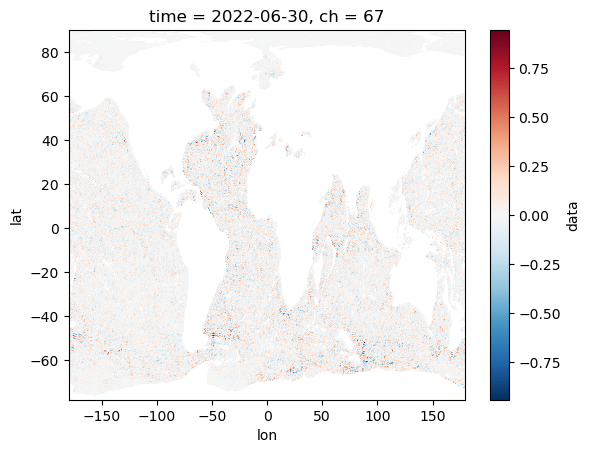

In [21]:
perturb_3.isel(time=0, ch=67)["data"].plot()

#### e. Go futher for perturbation 3_1 : from climatology

The general displacement idea is same. 
But let's make perturbation from climatology mean and anomaly. </br>
This method can reflect realistic sources of uncertainty in ocean state estimation.
Moreover, can be tuned to represent different scales of variability.

$$ dx = dt \cdot (\hat u + \alpha \cdot u')
$$
$$ dy = dt \cdot (\hat v + \alpha \cdot v')
$$
Where, $\hat \psi $ is mean field and $\psi'$ stands for anomalies field.
$\alpha$ is tunalble scalar which can represent spatially varying field.

For simplicty, let's assume that the error propagation due to flow is same for every depth. </br> 
***Displacement $dx$ and $dy$ are constant as a surfcae displacement.***

In [22]:
uv_clim = clim["data"].isel(ch=slice(3, 5))
nv_anom = perturb_2["data"].isel(ch=slice(3, 5))


In [23]:
# Same logic. take max values.
uhat = uv_clim.isel(ch=0).max()
uprime = nv_anom.isel(ch=0).max()
vhat = uv_clim.isel(ch=1).max()
vprime = nv_anom.isel(ch=1).max()

In [24]:
dt = 1
alpha = 1

dx = dt * (uhat + alpha * uprime)
dy = dt * (vhat + alpha * vprime)

dx_global = int(dx)
dy_global = int(dy)

In [25]:
dx, dy

(<xarray.DataArray 'data' ()> Size: 8B
 array(4.58608322)
 Coordinates:
     time     datetime64[ns] 8B 2022-07-01
     ch       int64 8B 3,
 <xarray.DataArray 'data' ()> Size: 8B
 array(4.25255701)
 Coordinates:
     time     datetime64[ns] 8B 2022-07-01
     ch       int64 8B 4)

In [26]:
depth_land_masks_corrected = {}

for depth in range(21):  # 0 to 20
    depth_key = f"d{depth}"
    
    print(f"  Processing depth {depth} using uv_depth['{depth_key}']...")
    # Create land mask for this depth using temperature channel
    temp_ch = depth_structure[depth]["channels"][0]  # First channel (temperature)
    temp_data = ds["data"].isel(ch=temp_ch)
    land_mask_depth = create_land_mask_from_channel(temp_data)

    depth_land_masks_corrected[depth] = land_mask_depth

# Display summary of displacement parameters by depth
print(f"\nDisplacement summary by depth:")
for depth in range(0, 21, 5):  # Show every 5th depth
    land_count = np.sum(depth_land_masks_corrected[depth].values)
    print(f"  Depth {depth:2d}: dx={dx_global:2d}, dy={dy_global:2d}, "
            f"land_pixels={land_count:,}")

# Create displaced dataset using deep copy
ocean_displaced = ds.copy(deep=True)

# Track processing statistics
start_time = time.time()
print(f"\nProcessing all {len(ds.ch)} channels with CORRECTED depth-dependent displacement...")
print(f"Time steps to process: {len(ds.time)}")
print("Progress: ", end="", flush=True)

total_operations = len(ds.ch) * len(ds.time)
completed_operations = 0

for t_idx in range(len(ds.time)):
    print(f"\n  Processing time step {t_idx + 1}/{len(ds.time)}...")
    
    for ch_idx in range(len(ds.ch)):
        # Show progress
        if completed_operations % 10 == 0 or completed_operations == total_operations - 1:
            progress = (completed_operations + 1) / total_operations * 100
            print(f"{progress:.0f}% ", end="", flush=True)
        
        # Determine which depth level this channel belongs to
        depth_level = None
        for depth, info in depth_structure.items():
            if ch_idx in info["channels"]:
                depth_level = depth
                break
        
        if depth_level is None:
            # Handle channels beyond our structure
            depth_level = 0  # Default to surface
            if ch_idx == 0 and t_idx == 0:  # Only warn once
                print(f"\n  Warning: Some channels not in depth structure, using surface parameters")
        
        # Get displacement parameters for this depth
        land_mask_depth = depth_land_masks_corrected[depth_level]
        
        # Get original data for current channel and time step
        original_data = ds.data.isel(time=t_idx, ch=ch_idx).values.copy()
        
        # Apply displacement with depth-specific parameters
        displaced_data = apply_ocean_displacement_complete(
            original_data, 
            dx_global, 
            dy_global, 
            land_mask_depth
        )
        
        # Store back into the dataset for all time steps
        ocean_displaced.data.values[t_idx, ch_idx, :, :] = displaced_data.copy()
        
        completed_operations += 1

print("\n")

# Processing summary
elapsed_time = time.time() - start_time
print(f"\n✅ CORRECTED DEPTH-DEPENDENT DISPLACEMENT COMPLETED!")
print(f"Processing time: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
print(f"Average time per operation: {elapsed_time/total_operations:.2f} seconds")
print(f"Total operations (channels × time steps): {total_operations}")

# Create perturbation dataset
print(f"\nCreating corrected perturbation dataset...")
perturb_3_1 = ocean_displaced - ds

# Verification statistics by time step
print(f"\nVerification by time step:")
for t_idx in range(len(ds.time)):
    print(f"\n  Time step {t_idx + 1}:")
    max_perturbation = np.nanmax(np.abs(perturb_3_1.data.isel(time=t_idx).values))
    mean_perturbation = np.nanmean(np.abs(perturb_3_1.data.isel(time=t_idx).values))
    print(f"    Max perturbation: {max_perturbation:.6f}")
    print(f"    Mean absolute perturbation: {mean_perturbation:.6f}")

print(f"\nOverall Statistics:")
print(f"  Max perturbation across all channels and times: {np.nanmax(np.abs(perturb_3_1.data.values)):.6f}")
print(f"  Mean absolute perturbation: {np.nanmean(np.abs(perturb_3_1.data.values)):.6f}")
print(f"  Total channels processed: {len(ds.ch)}")
print(f"  Total time steps processed: {len(ds.time)}")

print(f"\n✅ Variables created:")
print(f"  - ocean_displaced: Dataset with climatology-based displacement (all time steps)")
print(f"  - perturb_3_1: Climatology-based perturbation dataset (all time steps)")

  Processing depth 0 using uv_depth['d0']...
  Processing depth 1 using uv_depth['d1']...
  Processing depth 2 using uv_depth['d2']...
  Processing depth 3 using uv_depth['d3']...
  Processing depth 4 using uv_depth['d4']...
  Processing depth 5 using uv_depth['d5']...
  Processing depth 6 using uv_depth['d6']...
  Processing depth 7 using uv_depth['d7']...
  Processing depth 8 using uv_depth['d8']...
  Processing depth 9 using uv_depth['d9']...
  Processing depth 10 using uv_depth['d10']...
  Processing depth 11 using uv_depth['d11']...
  Processing depth 12 using uv_depth['d12']...
  Processing depth 13 using uv_depth['d13']...
  Processing depth 14 using uv_depth['d14']...
  Processing depth 15 using uv_depth['d15']...
  Processing depth 16 using uv_depth['d16']...
  Processing depth 17 using uv_depth['d17']...
  Processing depth 18 using uv_depth['d18']...
  Processing depth 19 using uv_depth['d19']...
  Processing depth 20 using uv_depth['d20']...

Displacement summary by depth:
 

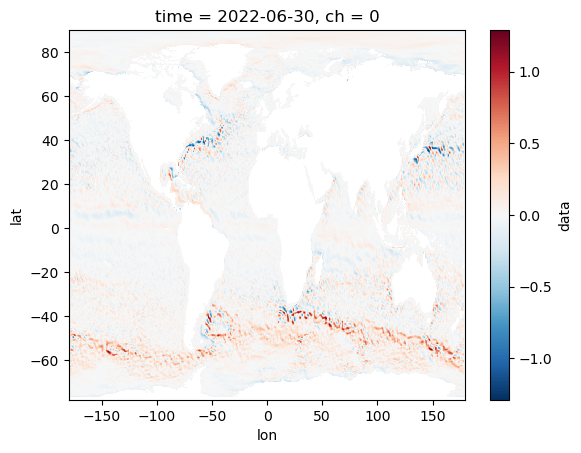

In [27]:
perturb_3_1.isel(time=0, ch=0)["data"].plot()


#### 4. Visualization: Displacement Effects in Dynamic Regions

Let's visualize the displacement effects, particularly focusing on dynamic ocean regions like the Gulf Stream where the displacement should be most evident due to higher anomaly magnitudes.

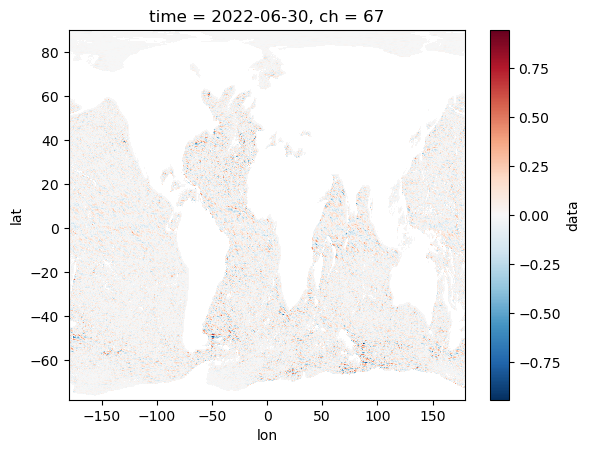

In [28]:
(perturb_3 - perturb_3_1).isel(time=0, ch=67)["data"].plot()

--
### 4. Difference between step time ###

Nothing more simplest then this. </br>
Only you need is bring next day GLO12 data. </br>
**But**, as this perturbations are came from another time window, this method is not a good approach. </br>
**But**, to begin to create ensemble, why not!

In [29]:
ncpath2 = "/Odyssey/public/glonet/2022-07-02_init_states"

nextday1= xr.open_dataset(ncpath2 + "/input1.nc")
nextday2= xr.open_dataset(ncpath2 + "/input2.nc")
nextday3= xr.open_dataset(ncpath2 + "/input3.nc")


nextday = xr.concat([nextday1, nextday2, nextday3], dim="ch")

nextday = nextday.assign_coords(ch=range(0, len(nextday.ch)))
# Reorder the dimensions to time-ch-lat-lon
nextday = nextday.transpose("time", "ch", "lat", "lon")

In [30]:
perturb_4_1 = ds.isel(time=0) - nextday.isel(time=0)
perturb_4_2 = ds.isel(time=1) - nextday.isel(time=1)

In [31]:
perturb_4 = xr.concat([perturb_4_1, perturb_4_2], dim="time")

In [32]:
perturb_4 = perturb_4.assign_coords(time=ds.time)
perturb_4 = perturb_4.transpose("time", "ch", "lat", "lon")

--
### 5. Gap from observations ###

The idea is simple as well. As it mentioned, the perturbation will be the difference between
analysis data and observation: `ds - observation`. </br>
However, realise this idea is not as easy as that idea is.
The observations are sparsly distirubted in both space and time references.  </br>
Therefore ***careful interpolation and representativeness handling*** is needed. </br>
Once, we could get a appropriate observation gap, we can directly tied to observational uncertainty.

Now, we got 5 perturbations of initial condition (or groud truth). </br>
Let's make 5 relevant ensemble members. 

In [33]:
ens1 = perturb_1 + ds
ens2 = perturb_2 + ds
ens3 = perturb_3 + ds
ens33 = perturb_3_1 + ds
ens4 = perturb_4 + ds

---
---
## Split Ensembles by Channel Coordinate ##

Now split the ensemble datasets back into the original input file format by dividing along the `ch` coordinate.

In [34]:
# First, let's check the channel dimensions of the original datasets to determine split points
print("Original dataset channel dimensions:")
print(f"ds1 channels: {len(ds1.ch) if hasattr(ds1, 'ch') else 'No ch dimension'}")
print(f"ds2 channels: {len(ds2.ch) if hasattr(ds2, 'ch') else 'No ch dimension'}")
print(f"ds3 channels: {len(ds3.ch) if hasattr(ds3, 'ch') else 'No ch dimension'}")

# Check data variables to understand the structure
print(f"\nds1 data vars: {list(ds1.data_vars.keys())}")
print(f"ds2 data vars: {list(ds2.data_vars.keys())}")
print(f"ds3 data vars: {list(ds3.data_vars.keys())}")

# Check the total channels in the combined dataset
print(f"\nCombined dataset total channels: {len(ds.ch)}")

# Determine split points based on original dataset sizes
if hasattr(ds1, 'ch'):
    split1 = len(ds1.ch)
    split2 = split1 + len(ds2.ch)
    print(f"\nChannel split points:")
    print(f"ds1: channels 0 to {split1-1}")
    print(f"ds2: channels {split1} to {split2-1}")
    print(f"ds3: channels {split2} to {len(ds.ch)-1}")
else:
    # If original datasets don't have ch dimension, assume equal splits
    total_channels = len(ds.ch)
    split1 = total_channels // 3
    split2 = 2 * total_channels // 3
    print(f"\nAssuming equal splits:")
    print(f"Part 1: channels 0 to {split1-1}")
    print(f"Part 2: channels {split1} to {split2-1}")
    print(f"Part 3: channels {split2} to {total_channels-1}")

Original dataset channel dimensions:
ds1 channels: 5
ds2 channels: 40
ds3 channels: 40

ds1 data vars: ['data']
ds2 data vars: ['data']
ds3 data vars: ['data']

Combined dataset total channels: 85

Channel split points:
ds1: channels 0 to 4
ds2: channels 5 to 44
ds3: channels 45 to 84


In [35]:
# Split the ensemble datasets back into original format
# Assuming the channels are split based on the original ds1, ds2, ds3 structure

if hasattr(ds1, 'ch'):
    # Use actual split points from original datasets
    split1 = len(ds1.ch)
    split2 = split1 + len(ds2.ch)
else:
    # Use equal splits if ch dimension not available in originals
    total_channels = len(ds.ch)
    split1 = total_channels // 3
    split2 = 2 * total_channels // 3

print("Splitting ensemble datasets...")

# Split ens1
ens1_input1 = ens1.sel(ch=slice(0, split1-1))
ens1_input2 = ens1.sel(ch=slice(split1, split2-1)) 
ens1_input3 = ens1.sel(ch=slice(split2, len(ds.ch)-1))

# Split ens2
ens2_input1 = ens2.sel(ch=slice(0, split1-1))
ens2_input2 = ens2.sel(ch=slice(split1, split2-1))
ens2_input3 = ens2.sel(ch=slice(split2, len(ds.ch)-1))

# Split ens3 (displaced)
ens3_input1 = ens3.sel(ch=slice(0, split1-1))
ens3_input2 = ens3.sel(ch=slice(split1, split2-1))
ens3_input3 = ens3.sel(ch=slice(split2, len(ds.ch)-1))

# Split ens3 (displaced)
ens33_input1 = ens33.sel(ch=slice(0, split1-1))
ens33_input2 = ens33.sel(ch=slice(split1, split2-1))
ens33_input3 = ens33.sel(ch=slice(split2, len(ds.ch)-1))

# Split ens4
ens4_input1 = ens4.sel(ch=slice(0, split1-1))
ens4_input2 = ens4.sel(ch=slice(split1, split2-1))
ens4_input3 = ens4.sel(ch=slice(split2, len(ds.ch)-1))

print("✓ All ensemble datasets split successfully!")

# Print shapes to verify
print(f"\nEnsemble 1 shapes:")
print(f"  input1: {ens1_input1.dims}")
print(f"  input2: {ens1_input2.dims}")
print(f"  input3: {ens1_input3.dims}")

print(f"\nEnsemble 2 shapes:")
print(f"  input1: {ens2_input1.dims}")
print(f"  input2: {ens2_input2.dims}")
print(f"  input3: {ens2_input3.dims}")

print(f"\nEnsemble 3 shapes:")
print(f"  input1: {ens3_input1.dims}")
print(f"  input2: {ens3_input2.dims}")
print(f"  input3: {ens3_input3.dims}")

print(f"\nEnsemble 4 shapes:")
print(f"  input1: {ens4_input1.dims}")
print(f"  input2: {ens4_input2.dims}")
print(f"  input3: {ens4_input3.dims}")

Splitting ensemble datasets...
✓ All ensemble datasets split successfully!

Ensemble 1 shapes:
  input1: FrozenMappingWarningOnValuesAccess({'time': 2, 'ch': 5, 'lat': 672, 'lon': 1440})
  input2: FrozenMappingWarningOnValuesAccess({'time': 2, 'ch': 40, 'lat': 672, 'lon': 1440})
  input3: FrozenMappingWarningOnValuesAccess({'time': 2, 'ch': 40, 'lat': 672, 'lon': 1440})

Ensemble 2 shapes:
  input1: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 5})
  input2: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 40})
  input3: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 40})

Ensemble 3 shapes:
  input1: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 5})
  input2: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 40})
  input3: FrozenMappingWarningOnValuesAccess({'time': 2, 'lat': 672, 'lon': 1440, 'ch': 40})

Ensemble 4 shapes:
  input1: F

### Save the split ensemble datasets to files

In [36]:
# Save the split ensemble datasets to NetCDF files
print("Saving ensemble datasets to files...")

# Save Ensemble 1 (Gaussian noise perturbation)
ens1_input1.to_netcdf(ncpath + "/ens1_input1.nc")
ens1_input2.to_netcdf(ncpath + "/ens1_input2.nc")
ens1_input3.to_netcdf(ncpath + "/ens1_input3.nc")
print("✓ Ensemble 1 (Gaussian) saved: ens1_input1.nc, ens1_input2.nc, ens1_input3.nc")

# Save Ensemble 2 (Climatological anomaly)
ens2_input1.to_netcdf(ncpath + "/ens2_input1.nc")
ens2_input2.to_netcdf(ncpath + "/ens2_input2.nc")
ens2_input3.to_netcdf(ncpath + "/ens2_input3.nc")
print("✓ Ensemble 2 (Climatological) saved: ens2_input1.nc, ens2_input2.nc, ens2_input3.nc")

# Save Ensemble 3 (Pixel displacement)
ens3_input1.to_netcdf(ncpath + "/ens3_input1.nc")
ens3_input2.to_netcdf(ncpath + "/ens3_input2.nc")
ens3_input3.to_netcdf(ncpath + "/ens3_input3.nc")
print("✓ Ensemble 3 (Displacement) saved: ens3_input1.nc, ens3_input2.nc, ens3_input3.nc")

# Save Ensemble 3 (Pixel displacement)
ens33_input1.to_netcdf(ncpath + "/ens33_input1.nc")
ens33_input2.to_netcdf(ncpath + "/ens33_input2.nc")
ens33_input3.to_netcdf(ncpath + "/ens33_input3.nc")
print("✓ Ensemble 33 (Displacement) saved: ens33_input1.nc, ens33_input2.nc, ens33_input3.nc")

# Save Ensemble 4 (Time difference)
ens4_input1.to_netcdf(ncpath + "/ens4_input1.nc")
ens4_input2.to_netcdf(ncpath + "/ens4_input2.nc")
ens4_input3.to_netcdf(ncpath + "/ens4_input3.nc")
print("✓ Ensemble 4 (Time difference) saved: ens4_input1.nc, ens4_input2.nc, ens4_input3.nc")

print("\n=== SUMMARY ===")
print(f"All ensemble datasets successfully split and saved!"
      f"< {ncpath} >")
print("Each ensemble contains 3 files matching the original input format:")
print("- input1.nc equivalent")
print("- input2.nc equivalent") 
print("- input3.nc equivalent")
print("\nEnsemble methods:")
print("1. Gaussian noise perturbation")
print("2. Climatological anomaly")
print("3. Proportional pixel displacement")
print("4. Time difference (next day)")

# Verify file sizes
import os
print(f"\nFile verification:")
for ens_num in range(1, 5):
    for input_num in range(1, 4):
        filename = f"ens{ens_num}_input{input_num}.nc"
        if os.path.exists(filename):
            size_mb = os.path.getsize(filename) / (1024 * 1024)
            print(f"  {filename}: {size_mb:.1f} MB")
        else:
            print(f"  {filename}: NOT FOUND")

Saving ensemble datasets to files...
✓ Ensemble 1 (Gaussian) saved: ens1_input1.nc, ens1_input2.nc, ens1_input3.nc
✓ Ensemble 1 (Gaussian) saved: ens1_input1.nc, ens1_input2.nc, ens1_input3.nc
✓ Ensemble 2 (Climatological) saved: ens2_input1.nc, ens2_input2.nc, ens2_input3.nc
✓ Ensemble 2 (Climatological) saved: ens2_input1.nc, ens2_input2.nc, ens2_input3.nc
✓ Ensemble 3 (Displacement) saved: ens3_input1.nc, ens3_input2.nc, ens3_input3.nc
✓ Ensemble 3 (Displacement) saved: ens3_input1.nc, ens3_input2.nc, ens3_input3.nc
✓ Ensemble 33 (Displacement) saved: ens33_input1.nc, ens33_input2.nc, ens33_input3.nc
✓ Ensemble 33 (Displacement) saved: ens33_input1.nc, ens33_input2.nc, ens33_input3.nc
✓ Ensemble 4 (Time difference) saved: ens4_input1.nc, ens4_input2.nc, ens4_input3.nc

=== SUMMARY ===
All ensemble datasets successfully split and saved!< /Odyssey/public/glonet/2022-07-01_init_states >
Each ensemble contains 3 files matching the original input format:
- input1.nc equivalent
- input2.n

---
---
## Comparative Analysis of Perturbation Methods ##

Let's create a comprehensive visualization to compare all four perturbation methods and understand their characteristics across different regions.